In [10]:
# This notebook has been modified (cleaned up) from the exact version used in the thesis,
# and verified to work with versions seen in the end

In [28]:
import qiskit
import matplotlib.pyplot as plt
'exec %matplotlib inline'
import numpy as np
import inspect

from qiskit import IBMQ, BasicAer, transpile
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit.library import MCMT

from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq.managed import IBMQJobManager

In [ ]:
# Number of qubits and bitstring
b = '10101'
n = len(b)

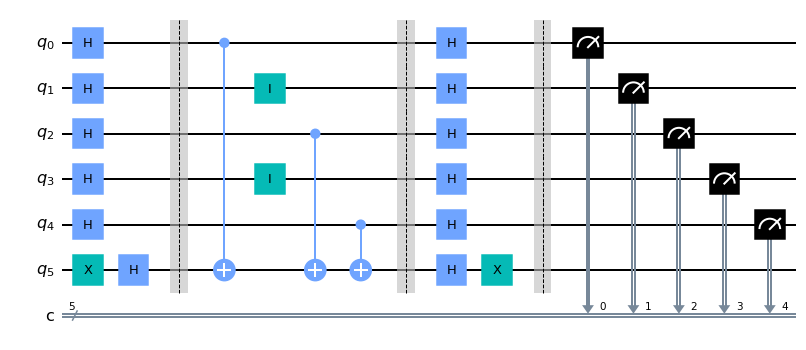

In [12]:
q = QuantumRegister(n+1, name='q')
c = ClassicalRegister(n, name='c')

qc = QuantumCircuit(q, c)

# Prepare the qubits
qc.x(q[n]) # initialising output register
for i in range(n+1):
    qc.h(q[i]) # Hadamard on all qubits
qc.barrier()

# Oracle function
for i in range(n):
    if (b[i] == '1'):
        qc.cx(i,n)
    else:
        qc.i(i)
qc.barrier()

# Before measurement
for i in range(n+1):
    qc.h(i)

qc.x(q[n]) 
qc.barrier()

# Measure 'input register'
for i in range(n):
    qc.measure(i,i)


qc.draw()

In [13]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

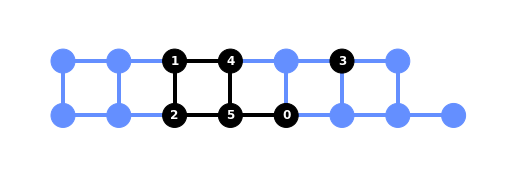

In [14]:
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_16_melbourne')

inspect.signature(transpile)
circ = transpile(qc, backend=backend, optimization_level=3)
plot_circuit_layout(circ, backend)

In [15]:
## Run circuits with jobmanager on IBM systems
shots=8192
name = 'Bernstein-Vazirani ' + str(n) + ' qubits'
job_manager = IBMQJobManager()
job = job_manager.run([circ],backend=backend,name=name,shots=shots)

In [21]:
job.statuses()

[<JobStatus.QUEUED: 'job is queued'>]

In [22]:
# Local simulator
backend_sim = BasicAer.get_backend('qasm_simulator')
job_sim = execute(qc, backend=backend_sim, shots=8192)

In [23]:
# Store results
exp_result = job.results().get_counts(circ)
sim_result = job_sim.result().get_counts(qc)

/usr/local/Cellar/jupyterlab/3.0.12/libexec/lib/python3.9/site-packages/qiskit/providers/ibmq/managed/managedjobset.py:394: DeprecationWarning: The ``IBMQJob.qobj()`` method is deprecated and will be removed in a future release. You can now pass circuits to ``IBMQBackend.run()`` and use ``IBMQJob.circuits()``, ``IBMQJob.backend_options()``, and ``IBMQJob.header()`` to retrieve circuits, run configuration, and Qobj header, respectively.
  for i, exp in enumerate(job.qobj().experiments):


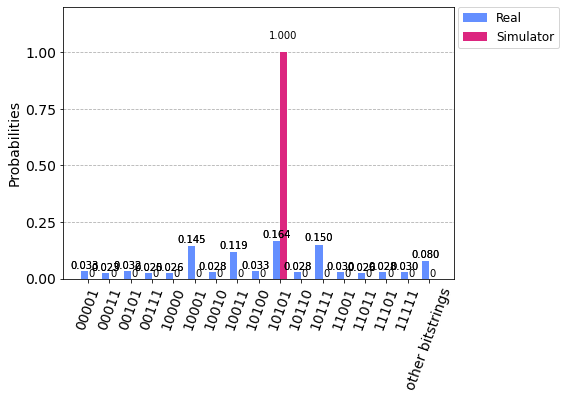

In [24]:
# Clear small noise measurements below treshold
shots = 8192
treshold = int(0.01*shots)
filtered_answer = {k: v for k,v in exp_result.items() if v >= treshold}
removed_counts = np.sum([ v for k,v in exp_result.items() if v < treshold])
filtered_answer['other bitstrings'] = removed_counts


legend = ['Real', 'Simulator']
plot_histogram([filtered_answer, sim_result], legend=legend,)

In [25]:
print(exp_result)

{'00000': 75, '00001': 267, '10000': 213, '10001': 1188, '10010': 227, '10011': 975, '10100': 272, '10101': 1347, '10110': 226, '10111': 1229, '11000': 30, '11001': 242, '11010': 36, '11011': 209, '11100': 49, '11101': 232, '11110': 46, '11111': 246, '00010': 60, '00011': 192, '00100': 64, '00101': 266, '00110': 60, '00111': 205, '01000': 13, '01001': 64, '01010': 11, '01011': 27, '01100': 14, '01101': 47, '01110': 12, '01111': 48}


In [29]:
for i in qiskit.__qiskit_version__.items():
    print(i)

('qiskit-terra', '0.17.1')
('qiskit-aer', '0.8.1')
('qiskit-ignis', '0.6.0')
('qiskit-ibmq-provider', '0.12.3')
('qiskit-aqua', '0.9.1')
('qiskit', '0.25.2')
('qiskit-nature', None)
('qiskit-finance', None)
('qiskit-optimization', None)
('qiskit-machine-learning', None)
